# Binary Classification with QBoost
This notebook uses QBoost, an algorithm developed all the way back in 2008 from a collaborative effort between Google and D-Wave. QBoost is used in this notebook to perform binary classification on two datasets, [MNIST (WARNING: No SSL!)](http://yann.lecun.com/exdb/mnist/), and [Breast Cancer Wisconsin (Original) Data Set](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original)) -- both from SciKit Learn's built-in datasets.

This is certainly not a demonstration of any kind of quantum speedup, advantage, or whatever buzzword is being over-used. This binary classifier samples two very small datasets, a task that takes a trivial amount of time on most classical computers, smartphones, and probably even some IoT devices availible to consumers. That said, 

# AWS Braket-specific Configuration

In [1]:
b = 'braket-your-braket-bucket-check-s3-console-after-onboard'
s3 = b, 'results'

## Runtime Variables

In [2]:
# Use Sampler from AWS Braket 'braket' (default) or D-Wave Leap 'leap'
sampler_vendor = 'braket'
# Run The Experiment
run_experiment = True
# Test Classifier on MNIST Dataset
mnist = True
# Test Classifier on WISC Dataset
wisc = True

## Required Imports

In [3]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, AdaBoostRegressor
import numpy as np
from copy import deepcopy
from sklearn import preprocessing, metrics
from sklearn.datasets import load_breast_cancer, fetch_openml
from sklearn.impute import SimpleImputer
from braket.ocean_plugin.braket_dwave_sampler import BraketDWaveSampler
from dwave.system import DWaveSampler
from dwave.system.composites import EmbeddingComposite
import numpy as np
from __future__ import print_function, division
import sys
from matplotlib import pyplot as plt

## Define Weight Penalty Function

In [4]:
def weight_penalty(prediction, y, percent = 0.1): 
    """
    For Regression we have to introduce a metric to penalize differences of the prediction from the label y.
    Percent gives the maximum deviation of the prediction from the label that is not penalized.
    """
    diff = np.abs(prediction-y)
    min_ = diff.min()
    max_ = diff.max()
    norm = (diff-min_)/(max_-min_)
    norm = 1.0*(norm  < percent)  
    return norm

## Define Weak Classifiers Based on DecisionTree

In [5]:
class WeakClassifiers(object):
    """
    Weak Classifiers based on DecisionTree
    """

    def __init__(self, n_estimators=50, max_depth=3):
        self.n_estimators = n_estimators
        self.estimators_ = []
        self.max_depth = max_depth
        self.__construct_wc()

    def __construct_wc(self):

        self.estimators_ = [DecisionTreeClassifier(max_depth=self.max_depth,
                                                   random_state=np.random.randint(1000000,10000000))
                            for _ in range(self.n_estimators)]

    def fit(self, X, y):
        """
        fit estimators
        :param X:
        :param y:
        :return:
        """

        self.estimator_weights = np.zeros(self.n_estimators)

        d = np.ones(len(X)) / len(X)
        for i, h in enumerate(self.estimators_):
            h.fit(X, y, sample_weight=d)
            pred = h.predict(X)
            eps = d.dot(pred != y)
            if eps == 0: # to prevent divided by zero error
                eps = 1e-20
            w = (np.log(1 - eps) - np.log(eps)) / 2
            d = d * np.exp(- w * y * pred)
            d = d / d.sum()
            self.estimator_weights[i] = w

    def predict(self, X):
        """
        predict label of X
        :param X:
        :return:
        """

        if not hasattr(self, 'estimator_weights'):
            raise Exception('Not Fitted Error!')

        y = np.zeros(len(X))

        for (h, w) in zip(self.estimators_, self.estimator_weights):
            y += w * h.predict(X)

        y = np.sign(y)

        return y

    def copy(self):

        classifier = WeakClassifiers(n_estimators=self.n_estimators, max_depth=self.max_depth)
        classifier.estimators_ = deepcopy(self.estimators_)
        if hasattr(self, 'estimator_weights'):
            classifier.estimator_weights = np.array(self.estimator_weights)

        return classifier

## Define QBoost Classifier

In [6]:
class QBoostClassifier(WeakClassifiers):
    """
    Qboost Classifier
    """
    def __init__(self, n_estimators=50, max_depth=3):
        super(QBoostClassifier, self).__init__(n_estimators=n_estimators,
                                              max_depth=max_depth)

    def fit(self, X, y, sampler, lmd=0.2, **kwargs):

        n_data = len(X)

        # step 1: fit weak classifiers
        super(QBoostClassifier, self).fit(X, y)

        # step 2: create QUBO
        hij = []
        for h in self.estimators_:
            hij.append(h.predict(X))

        hij = np.array(hij)
        # scale hij to [-1/N, 1/N]
        hij = 1. * hij / self.n_estimators

        ## Create QUBO
        qii = n_data * 1. / (self.n_estimators ** 2) + lmd - 2 * np.dot(hij, y)
        qij = np.dot(hij, hij.T)
        Q = dict()
        Q.update(dict(((k, k), v) for (k, v) in enumerate(qii)))
        for i in range(self.n_estimators):
            for j in range(i + 1, self.n_estimators):
                Q[(i, j)] = qij[i, j]

        # step 3: optimize QUBO
        res = sampler.sample_qubo(Q, **kwargs)
        samples = np.array([[samp[k] for k in range(self.n_estimators)] for samp in res])

        # take the optimal solution as estimator weights
        self.estimator_weights = samples[0]

    def predict(self, X):
        n_data = len(X)
        pred_all = np.array([h.predict(X) for h in self.estimators_])
        temp1 = np.dot(self.estimator_weights, pred_all)
        T1 = np.sum(temp1, axis=0) / (n_data * self.n_estimators * 1.)
        y = np.sign(temp1 - T1) #binary classes are either 1 or -1

        return y


## Define a Weak Regressor based on DecisionTreeRegressor

In [7]:
class WeakRegressor(object):
    """
    Weak Regressor based on DecisionTreeRegressor
    """

    def __init__(self, n_estimators=50, max_depth=3, DT = True, Ada = False, ):
        self.n_estimators = n_estimators
        self.estimators_ = []
        self.max_depth = max_depth
        self.__construct_wc()

    def __construct_wc(self):

        self.estimators_ = [DecisionTreeRegressor(max_depth=self.max_depth,
                                                   random_state=np.random.randint(1000000,10000000))
                            for _ in range(self.n_estimators)]
#        self.estimators_ = [AdaBoostRegressor(random_state=np.random.randint(1000000,10000000))
#                            for _ in range(self.n_estimators)]

    def fit(self, X, y):
        """
        fit estimators
        :param X:
        :param y:
        :return:
        """

        self.estimator_weights = np.zeros(self.n_estimators) #initialize all estimator weights to zero

        d = np.ones(len(X)) / len(X)
        for i, h in enumerate(self.estimators_): #fit all estimators
            h.fit(X, y, sample_weight=d)
            pred = h.predict(X)
            # For classification one simply compares (pred != y)
            # For regression we have to define another metric
            norm = weight_penalty(pred, y)
            eps = d.dot(norm)
            if eps == 0: # to prevent divided by zero error
                eps = 1e-20
            w = (np.log(1 - eps) - np.log(eps)) / 2
            d = d * np.exp(- w * y * pred)
            d = d / d.sum()
            self.estimator_weights[i] = w

    def predict(self, X):
        """
        predict label of X
        :param X:
        :return:
        """

        if not hasattr(self, 'estimator_weights'):
            raise Exception('Not Fitted Error!')

        y = np.zeros(len(X))

        for (h, w) in zip(self.estimators_, self.estimator_weights):
            y += w * h.predict(X)

        y = np.sign(y)

        return y

    def copy(self):

        classifier = WeakRegressor(n_estimators=self.n_estimators, max_depth=self.max_depth)
        classifier.estimators_ = deepcopy(self.estimators_)
        if hasattr(self, 'estimator_weights'):
            classifier.estimator_weights = np.array(self.estimator_weights)

        return classifier

## Define QBoost Regressor

In [8]:
class QBoostRegressor(WeakRegressor):
    """
    Qboost Regressor
    """
    def __init__(self, n_estimators=50, max_depth=3):
        super(QBoostRegressor, self).__init__(n_estimators=n_estimators,
                                              max_depth=max_depth)
        self.Qu = 0.0
        self.hij = 0.0
        self.var1 = 0.0
        self.qij = 0.0

    def fit(self, X, y, sampler, lmd=0.2, **kwargs):

        n_data = len(X)

        # step 1: fit weak classifiers
        super(QBoostRegressor, self).fit(X, y)

        # step 2: create QUBO
        hij = []
        for h in self.estimators_:
            hij.append(h.predict(X))

        hij = np.array(hij)
        # scale hij to [-1/N, 1/N]
        hij = 1. * hij / self.n_estimators
        self.hij = hij
        ## Create QUBO
        qii = n_data * 1. / (self.n_estimators ** 2) + lmd - 2 * np.dot(hij, y)
        self.var1 = qii
        qij = np.dot(hij, hij.T)
        self.qij = qij
        Q = dict()
        Q.update(dict(((k, k), v) for (k, v) in enumerate(qii)))
        for i in range(self.n_estimators):
            for j in range(i + 1, self.n_estimators):
                Q[(i, j)] = qij[i, j]

        self.Qu = Q
        # step 3: optimize QUBO
        res = sampler.sample_qubo(Q, **kwargs)
        samples = np.array([[samp[k] for k in range(self.n_estimators)] for samp in res])

        # take the optimal solution as estimator weights
        # self.estimator_weights = np.mean(samples, axis=0)
        self.estimator_weights = samples[0]

    def predict(self, X):
        n_data = len(X)
        pred_all = np.array([h.predict(X) for h in self.estimators_])
        temp1 = np.dot(self.estimator_weights, pred_all)
        norm = np.sum(self.estimator_weights)
        if norm > 0:
            y = temp1 / norm
        else:
            y = temp1
        return y

## Define Function to Quantum Boost Existing Weak Classifiers

In [9]:
class QboostPlus(object):
    """
    Only for Classifiers
    Quantum boost existing (weak) classifiers
    """

    def __init__(self, weak_classifier_list):
        self.estimators_ = weak_classifier_list
        self.n_estimators = len(self.estimators_)
        self.estimator_weights = np.ones(self.n_estimators) #estimator weights will be binary (Dwave output)

    def fit(self, X, y, sampler, lmd=0.2, **kwargs):

        n_data = len(X)
        # step 1: create QUBO
        hij = []
        for h in self.estimators_:
            hij.append(h.predict(X))

        hij = np.array(hij)
        # scale hij to [-1/N, 1/N]
        hij = 1. * hij / self.n_estimators

        ## Create QUBO
        qii = n_data * 1. / (self.n_estimators ** 2) + lmd - 2 * np.dot(hij, y)
        qij = np.dot(hij, hij.T)
        Q = dict()
        Q.update(dict(((k, k), v) for (k, v) in enumerate(qii)))
        for i in range(self.n_estimators):
            for j in range(i + 1, self.n_estimators):
                Q[(i, j)] = qij[i, j]

        # step 3: optimize QUBO
        res = sampler.sample_qubo(Q, **kwargs)
        samples = np.array([[samp[k] for k in range(self.n_estimators)] for samp in res])

        # take the optimal solution as estimator weights
        self.estimator_weights = samples[0]

    def predict(self, X):

        n_data = len(X)
        T = 0
        y = np.zeros(n_data)
        for i, h in enumerate(self.estimators_):
            y0 = self.estimator_weights[i] * h.predict(X)  # prediction of weak classifier
            y += y0
            T += np.sum(y0)

        y = np.sign(y - T / (n_data*self.n_estimators))

        return y

## Define Function to Quantum Boost Weak Regressors

In [10]:
class QboostPlusRegression(object):
    """
    Quantum boost existing (weak) regressors
    """

    def __init__(self, weak_Regressor_list):
        self.estimators_ = weak_Regressor_list
        self.n_estimators = len(self.estimators_)
        self.estimator_weights = np.ones(self.n_estimators)

    def fit(self, X, y, sampler, lmd=0.2, **kwargs):

        n_data = len(X)
        # step 1: create QUBO
        hij = []
        for h in self.estimators_:
            hij.append(h.predict(X))

        hij = np.array(hij)
        # scale hij to [-1/N, 1/N]
        hij = 1. * hij / self.n_estimators

        ## Create QUBO
        qii = n_data * 1. / (self.n_estimators ** 2) + lmd - 2 * np.dot(hij, y)
        qij = np.dot(hij, hij.T)
        Q = dict()
        Q.update(dict(((k, k), v) for (k, v) in enumerate(qii)))
        for i in range(self.n_estimators):
            for j in range(i + 1, self.n_estimators):
                Q[(i, j)] = qij[i, j]

        # step 3: optimize QUBO
        res = sampler.sample_qubo(Q, **kwargs)
        samples = np.array([[samp[k] for k in range(self.n_estimators)] for samp in res])

        # take the optimal solution as estimator weights
        self.estimator_weights = samples[0]

    def predict(self, X):

        n_data = len(X)
        T = 0
        y = np.zeros(n_data)
        for i, h in enumerate(self.estimators_):
            y0 = self.estimator_weights[i] * h.predict(X)  # prediction of weak classifier
            y += y0
            T += np.sum(y0)

        norm = np.sum(self.estimator_weights)
        if norm > 0:
            y = y / norm
        else:
            y = y

        return y



## Define Function for Calculating Accuracy

In [11]:
def metric(y, y_pred):

    return metrics.accuracy_score(y, y_pred)

## Define Function for Training a Model

In [12]:
def train_model(X_train, y_train, X_test, y_test, lmd, sampler_vendor):
    """
    Train qboost model

    :param X_train: train input
    :param y_train: train label
    :param X_test: test input
    :param y_test: test label
    :param lmd: lmbda to control regularization term
    :return:
    """
    NUM_READS = 3000
    NUM_WEAK_CLASSIFIERS = 35
    # lmd = 0.5
    TREE_DEPTH = 3
    
    # define sampler
    if sampler_vendor == 'braket':
        dwave_sampler = BraketDWaveSampler(s3)
    elif sampler_vendor == 'leap':
        dwave_sampler = DWaveSampler()
    elif sampler_vendor == None:
        print('ERROR: Sampler not specified.')
        dwave_sampler = None
    else:
        print('ERROR: Unable to create sampler, invalid sampler specified.')
        
    # embed sampler using EmbeddingComposite
    emb_sampler = EmbeddingComposite(dwave_sampler)

    N_train = len(X_train)
    N_test = len(X_test)

    print("\n======================================")
    print("Train#: %d, Test: %d" %(N_train, N_test))
    print('Num weak classifiers:', NUM_WEAK_CLASSIFIERS)
    print('Tree depth:', TREE_DEPTH)


    # input: dataset X and labels y (in {+1, -1}

    # Preprocessing data
    # imputer = SimpleImputer()
    scaler = preprocessing.StandardScaler()     # standardize features
    normalizer = preprocessing.Normalizer()     # normalize samples

    # X = imputer.fit_transform(X)
    X_train = scaler.fit_transform(X_train)
    X_train = normalizer.fit_transform(X_train)

    # X_test = imputer.fit_transform(X_test)
    X_test = scaler.fit_transform(X_test)
    X_test = normalizer.fit_transform(X_test)

    ## Adaboost
    print('\nAdaboost')

    clf = AdaBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS)

    # scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
    print('fitting...')
    clf.fit(X_train, y_train)

    hypotheses_ada = clf.estimators_
    # clf.estimator_weights_ = np.random.uniform(0,1,size=NUM_WEAK_CLASSIFIERS)
    print('testing...')
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)

    print('accu (train): %5.2f'%(metric(y_train, y_train_pred)))
    print('accu (test): %5.2f'%(metric(y_test, y_test_pred)))

    # Ensembles of Decision Tree
    print('\nDecision tree')

    clf2 = WeakClassifiers(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf2.fit(X_train, y_train)

    y_train_pred2 = clf2.predict(X_train)
    y_test_pred2 = clf2.predict(X_test)
    print(clf2.estimator_weights)

    print('accu (train): %5.2f' % (metric(y_train, y_train_pred2)))
    print('accu (test): %5.2f' % (metric(y_test, y_test_pred2)))

    # Ensembles of Decision Tree
    print('\nQBoost')

    DW_PARAMS = {'num_reads': NUM_READS,
                 'auto_scale': True,
                 # "answer_mode": "histogram",
                 'num_spin_reversal_transforms': 10,
                 # 'annealing_time': 10,
                 }

    clf3 = QBoostClassifier(n_estimators=NUM_WEAK_CLASSIFIERS, max_depth=TREE_DEPTH)
    clf3.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)

    y_train_dw = clf3.predict(X_train)
    y_test_dw = clf3.predict(X_test)

    print(clf3.estimator_weights)

    print('accu (train): %5.2f' % (metric(y_train, y_train_dw)))
    print('accu (test): %5.2f' % (metric(y_test, y_test_dw)))


    # Ensembles of Decision Tree
    print('\nQBoostPlus')
    clf4 = QboostPlus([clf, clf2, clf3])
    clf4.fit(X_train, y_train, emb_sampler, lmd=lmd, **DW_PARAMS)
    y_train4 = clf4.predict(X_train)
    y_test4 = clf4.predict(X_test)
    print(clf4.estimator_weights)

    print('accu (train): %5.2f' % (metric(y_train, y_train4)))
    print('accu (test): %5.2f' % (metric(y_test, y_test4)))


    print("=============================================")
    print("Method \t Adaboost \t DecisionTree \t Qboost \t QboostIt")
    print("Train\t %5.2f \t\t %5.2f \t\t\t %5.2f \t\t %5.2f"% (metric(y_train, y_train_pred),
                                                               metric(y_train, y_train_pred2),
                                                               metric(y_train, y_train_dw),
                                                               metric(y_train, y_train4)))
    print("Test\t %5.2f \t\t %5.2f \t\t\t %5.2f \t\t %5.2f"% (metric(y_test, y_test_pred),
                                                              metric(y_test,y_test_pred2),
                                                              metric(y_test, y_test_dw),
                                                              metric(y_test, y_test4)))
    print("=============================================")

    plt.subplot(211)
    plt.bar(range(len(y_test)), y_test)
    plt.subplot(212)
    plt.bar(range(len(y_test)), y_test_dw)
    plt.show()

    return

## Run the Experiment!
This tests our classifier on two datasets, first [MNIST (WARNING: No SSL!)](http://yann.lecun.com/exdb/mnist/), then [Breast Cancer Wisconsin (Original) Data Set](https://archive.ics.uci.edu/ml/datasets/breast+cancer+wisconsin+(original).


Train#: 3333, Test: 1667
Num weak classifiers: 35
Tree depth: 3

Adaboost
fitting...
testing...
accu (train):  0.86
accu (test):  0.83

Decision tree
[0.58204807 0.49024972 0.38958053 0.42547385 0.26738606 0.3189999
 0.34184563 0.27676042 0.37951279 0.21577486 0.33583947 0.34912615
 0.37422525 0.31215134 0.29590478 0.27917402 0.28313412 0.18158317
 0.31690535 0.2602812  0.22597227 0.24789463 0.16682482 0.3179388
 0.23042279 0.39515907 0.37067034 0.20169936 0.28886562 0.43300414
 0.4352297  0.31234166 0.23901466 0.39598776 0.28330392]
accu (train):  0.98
accu (test):  0.89

QBoost
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
accu (train):  0.98
accu (test):  0.90

QBoostPlus
[1 1 1]
accu (train):  0.98
accu (test):  0.89
Method 	 Adaboost 	 DecisionTree 	 Qboost 	 QboostIt
Train	  0.86 		  0.98 			  0.98 		  0.98
Test	  0.83 		  0.89 			  0.90 		  0.89


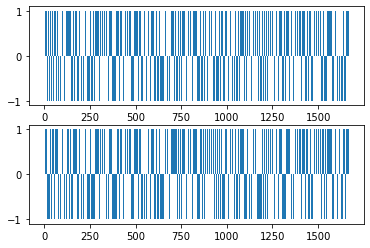


Train#: 379, Test: 190
Num weak classifiers: 35
Tree depth: 3

Adaboost
fitting...
testing...
accu (train):  1.00
accu (test):  0.97

Decision tree
[1.80410578 1.59827985 1.93452176 1.7257916  1.51111906 1.84446929
 1.38874752 1.37445901 1.62789563 1.38994524 1.5814096  2.43586949
 1.98568216 1.46540255 1.65100799 1.31047453 1.52530683 1.7332396
 1.42666629 1.61361036 1.2021996  1.06466341 1.5711889  1.15060123
 1.62183222 1.10257354 1.14481147 0.98463299 1.48586854 1.52933254
 1.37137464 1.22256277 1.42006973 1.21912093 1.51031667]
accu (train):  1.00
accu (test):  0.98

QBoost
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
accu (train):  1.00
accu (test):  0.98

QBoostPlus
[1 1 1]
accu (train):  1.00
accu (test):  0.98
Method 	 Adaboost 	 DecisionTree 	 Qboost 	 QboostIt
Train	  1.00 		  1.00 			  1.00 		  1.00
Test	  0.97 		  0.98 			  0.98 		  0.98


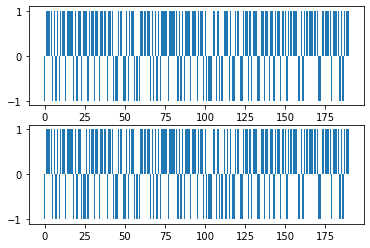

In [13]:
if run_experiment == True:

    if mnist == True:

        mnist = fetch_openml('mnist_784', version=1)

        idx = np.arange(len(mnist['data']))
        np.random.shuffle(idx)

        n = 5000
        idx = idx[:n]
        idx_train = idx[:2*n//3]
        idx_test = idx[2*n//3:]

        X_train = mnist['data'][idx_train]
        X_test = mnist['data'][idx_test]

        # Note: mnist['target'] is an array of string numbers, hence the comparison with '4'
        y_train = 2*(mnist['target'][idx_train] <= '4') - 1
        y_test = 2*(mnist['target'][idx_test] <= '4') - 1

        clfs = train_model(X_train, y_train, X_test, y_test, 1.0, sampler_vendor)

    if wisc == True:

        wisc = load_breast_cancer()

        idx = np.arange(len(wisc.target))
        np.random.shuffle(idx)

        # train on a random 2/3 and test on the remaining 1/3
        idx_train = idx[:2*len(idx)//3]
        idx_test = idx[2*len(idx)//3:]

        X_train = wisc.data[idx_train]
        X_test = wisc.data[idx_test]

        y_train = 2 * wisc.target[idx_train] - 1  # binary -> spin
        y_test = 2 * wisc.target[idx_test] - 1

        clfs = train_model(X_train, y_train, X_test, y_test, 1.0, sampler_vendor)

## References

H. Neven, V. S. Denchev, G. Rose, and W. G. Macready, "Training a Binary
Classifier with the Quantum Adiabatic Algorithm",
[arXiv:0811.0416v1](https://arxiv.org/pdf/0811.0416.pdf)

Y. LeCun, L. Bottou, Y. Bengio, and P. Haffner. "Gradient-based learning applied to document recognition." Proceedings of the IEEE, 86(11):2278-2324, November 1998. [doi:10.1109/5.726791](https://ieeexplore.ieee.org/document/726791)

O. L. Mangasarian and W. H. Wolberg: "Cancer diagnosis via linear programming", SIAM News, Volume 23, Number 5, September 1990, pp 1 & 18.

William H. Wolberg and O.L. Mangasarian: "Multisurface method of pattern separation for medical diagnosis applied to breast cytology", Proceedings of the National Academy of Sciences, U.S.A., Volume 87, December 1990, pp 9193-9196.

O. L. Mangasarian, R. Setiono, and W.H. Wolberg: "Pattern recognition via linear programming: Theory and application to medical diagnosis", in: "Large-scale numerical optimization", Thomas F. Coleman and Yuying Li, editors, SIAM Publications, Philadelphia 1990, pp 22-30.

K. P. Bennett & O. L. Mangasarian: "Robust linear programming discrimination of two linearly inseparable sets", Optimization Methods and Software 1, 1992, 23-34 (Gordon & Breach Science Publishers).